In [1]:
import pandas as pd
from tqdm.auto import tqdm
from util import *
from stationUtil import *
from graph import *
from glob import glob
import json

FileNotFoundError: [Errno 2] No such file or directory: '../trimmed_data/stationNameCode.pickel'

In [ ]:
# DEMAND_GRAPH_PATH = "../trimmed_data/demand_graph.pickle"
# demand = loadPickle(DEMAND_GRAPH_PATH)
f_list = glob("../trimmed_data/A001_20*.csv.*")
demand = [loadPickle(p) for p in f_list]
demand[0].keys().__len__()

12468

In [ ]:
# 아무것도 제외 하지 않으면 완행열차와 동일하다.
UNITFACTOR_P1KM_TO_1KM = 1 / 10
UNITFACTOR_1SEC_TO_1HOUR = 1 / 3600
EXCLUDE_STATION = []
g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
g_dist = dist_weight_graph()

sCode_start, sCode_end = 95, 301
calc_total_path_weight(g_time, sCode_start, sCode_end), calc_total_path_weight(
    g_dist, sCode_start, sCode_end
)  # (Second, 0.1km)

(4547.9284707102415, 331)

In [ ]:
def od_metric(scode_start, scode_end):
    month_size = len(demand)
    d_list = []
    for d in demand:
        try:
            d_list.append(d[(scode_start, scode_end)])
        except:
            continue
    return sum(d_list)/month_size
        
def unit_tranfer_flux_metric(scode_start, scode_end, g_dist=g_dist):
    path_dist = (
        calc_total_path_weight(g_dist, scode_start, scode_end) * UNITFACTOR_P1KM_TO_1KM
    )
    path_od = od_metric(scode_start, scode_end)
    return (path_dist, path_od)

In [ ]:
# Calc Flux Metric
dist = {}
od = {}
flux_metric = {}
s_namecode = loadPickle("../trimmed_data/stationNameCode.pickel").values()
s_namecode = set(s_namecode)

for target_scode in tqdm(s_namecode):
    for calc_scode in s_namecode:
        p_dist, p_od = unit_tranfer_flux_metric(target_scode, calc_scode)
        flux_metric[(target_scode, calc_scode)] = p_dist * p_od
        dist[(target_scode, calc_scode)] = p_dist
        od[(target_scode, calc_scode)] = p_od

sum_flux_IO = {scode: [0, 0] for scode in s_namecode}
for target_scode in tqdm(s_namecode):
    sflux_IN,sflux_OUT = [],[]
    
    for calc_scode in s_namecode:
        sflux_IN.append(flux_metric[(target_scode, calc_scode)])
        sflux_OUT.append(flux_metric[(calc_scode, target_scode)])
    
    sum_flux_IO[target_scode][0] = sum(sflux_IN)
    sum_flux_IO[target_scode][1] = sum(sflux_OUT)

sum_flux_IO[301] = sum_flux_IO[208]
sum_flux_IO[401] = sum_flux_IO[309]

  4%|▎         | 4/114 [00:00<00:09, 11.73it/s]

100%|██████████| 114/114 [00:00<00:00, 1154.87it/s]


In [ ]:
SUM_FLUX_METRIC = pd.DataFrame(sum_flux_IO).T
SUM_FLUX_METRIC = SUM_FLUX_METRIC.rename(columns={0: "IN_FLUX", 1: "OUT_FLUX"})
SUM_FLUX_METRIC.index.name = "scode"

SUM_FLUX_METRIC.to_json("../database/SUM_FLUX_IO_METRIC.json")
# SUM_FLUX_METRIC.loc[line_num_to_range(4), :].head()

# 정규화함. 호선 별로
SUM_FLUX_METRIC_GRADE = SUM_FLUX_METRIC.copy(deep=True)
for line in (1, 2, 3, 4):
    SUM_FLUX_METRIC_GRADE.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"] = SUM_FLUX_METRIC_GRADE.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"].rank(method="min")
    SUM_FLUX_METRIC_GRADE.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"] /= SUM_FLUX_METRIC_GRADE.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"].max()
    SUM_FLUX_METRIC_GRADE.loc[line_num_to_range(line), "IN_FLUX":"OUT_FLUX"] *= 10

In [ ]:
SAVE_PATH = "../database"
IMPLICIT_METRIC = pd.read_csv(f"{SAVE_PATH}/IMPLICIT_METRIC.csv", encoding="UTF-8")
IMPLICIT_METRIC = IMPLICIT_METRIC.set_index("scode")

IMPLICIT_METRIC.to_json("../database/IMPLICIT_METRIC.json")
# IMPLICIT_METRIC.loc[line_num_to_range(4), :].head()

# 정규화함. 호선 별로
IMPLICIT_METRIC_GRADE = IMPLICIT_METRIC.copy(deep=True)
for line in (1, 2, 3, 4):
    IMPLICIT_METRIC_GRADE.loc[line_num_to_range(line), "직장인구":"유동인구"] = IMPLICIT_METRIC_GRADE.loc[line_num_to_range(line), "직장인구":"유동인구"].rank(method="min")
    IMPLICIT_METRIC_GRADE.loc[line_num_to_range(line), "직장인구":"유동인구"] /= IMPLICIT_METRIC_GRADE.loc[line_num_to_range(line), "직장인구":"유동인구"].max()
    IMPLICIT_METRIC_GRADE.loc[line_num_to_range(line), "직장인구":"유동인구"] *= 10

IMPLICIT_METRIC_GRADE.loc[line_num_to_range(4), :].head()

,직장인구,주거인구,유동인구
scode,,,
401,6.428571,7.142857,7.857143
402,7.857143,8.571429,9.285714
403,10.000000,10.000000,10.000000
404,9.285714,9.285714,8.571429
405,8.571429,7.857143,7.142857


In [ ]:
FLUX_METRIC_MEAN = SUM_FLUX_METRIC_GRADE.mean(axis=1)
IMPLICIT_METRIC_MEAN = IMPLICIT_METRIC_GRADE.mean(axis=1)

DF_METRIC = pd.concat([FLUX_METRIC_MEAN, IMPLICIT_METRIC_MEAN], axis=1)
DF_METRIC = DF_METRIC.rename(columns={0: "FLUX", 1: "IMPLICIT"})

DF_METRIC["LINE"] = DF_METRIC.index
DF_METRIC["LINE"] = DF_METRIC["LINE"].apply(get_line)
DF_METRIC.head()

,FLUX,IMPLICIT,LINE
scode,,,
95,4.500,0.750000,1
96,1.875,1.666667,1
97,3.000,3.250000,1
98,0.875,4.916667,1
99,1.500,5.000000,1


In [ ]:
def calc_grade(_tup):
    flux, impl = _tup
    if flux < 2 and impl < 2:
        return 5
    elif flux < 4 and impl < 4:
        return 4
    elif flux < 6 and impl < 6:
        return 3
    elif flux < 8 and impl < 8:
        return 2
    elif flux <= 10 and impl <= 10:
        return 1


# Calculate GRADE
DF_METRIC["GRADE"] = (
    DF_METRIC["FLUX"].apply(str) + "," + DF_METRIC["IMPLICIT"].apply(str)
)
DF_METRIC["GRADE"] = DF_METRIC["GRADE"].apply(
    lambda _X: tuple(map(float, _X.split(",")))
)
DF_METRIC["GRADE"] = DF_METRIC["GRADE"].apply(calc_grade)

DF_METRIC.to_json("../database/METRIC_INTEGRATED.json")
DF_METRIC.head()

,FLUX,IMPLICIT,LINE,GRADE
scode,,,,
95,4.500,0.750000,1,3
96,1.875,1.666667,1,5
97,3.000,3.250000,1,4
98,0.875,4.916667,1,3
99,1.500,5.000000,1,3


In [ ]:
GRADE_CONDITION = [DF_METRIC["GRADE"] == g for g in (1, 2, 3, 4, 5)]
LINE_CONDITION = [DF_METRIC["LINE"] == l for l in (1, 2, 3, 4)]

In [ ]:
def draw_func(LINE):
    ax = DF_METRIC[LINE_CONDITION[LINE - 1]].plot.scatter(
        x="FLUX", y="IMPLICIT", c="GRADE", colormap="RdBu"
    )
    return ax, ax.get_figure()


def get_grade(LINE, GRADE):
    arr = []
    for g in range(GRADE):
        arr.extend(
            DF_METRIC[LINE_CONDITION[LINE - 1] & GRADE_CONDITION[g - 1]].index.to_list()
        )
    arr.sort()

    return arr


def get_exclude_list(LINE, GRADE):
    sCodes = [*line_num_to_range(LINE)]
    for grade in get_grade(LINE, GRADE):
        if grade in sCodes:
            sCodes.pop(sCodes.index(grade))

    if [*line_num_to_range(LINE)][0] in sCodes:
        sCodes.pop(0)
    if [*line_num_to_range(LINE)][-1] in sCodes:
        sCodes.pop(-1)

    return sCodes


assert 0 == len(set(get_grade(1, 1)) & set(get_exclude_list(1, 1)))

In [ ]:
df_senario = pd.DataFrame(columns=["TIME", "SPEED", "LINE", "GRADE"])
for line in [1, 2, 3, 4]:
    for grade in [5, 4, 3, 2, 1]:
        EXCLUDE_STATION = get_exclude_list(line, grade)
        g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
        g_dist = dist_weight_graph()

        df_line = (
            calc_line_spend_time(line, g_time),
            calc_line_speed(line, g_dist, g_time),
            line,
            grade,
        )
        df_senario.loc[len(df_senario.index)] = df_line

df_senario = df_senario.sort_values(by=["LINE", "GRADE"])
df_senario["LINE"] = df_senario["LINE"].apply(int)
df_senario["GRADE"] = df_senario["GRADE"].apply(int)

df_senario.to_json("../database/SENARIO.json")
df_senario

,TIME,SPEED,LINE,GRADE
4,3785.0,37.949802,1,1
3,4185.0,34.322581,1,2
2,4415.0,32.534541,1,3
1,4645.0,30.923574,1,4
0,4745.0,30.271865,1,5
9,4220.0,38.559242,2,1
8,4540.0,35.841410,2,2
7,4740.0,34.329114,2,3
6,4980.0,32.674699,2,4
5,5040.0,32.285714,2,5


LINE, GRADE = (2, 1)
38.56 [km/h]
4220 [second]
[237, 238, 239] is Selected by GRADE 1 
[202, 203, 204, 205, 206] ... and more will be exclude


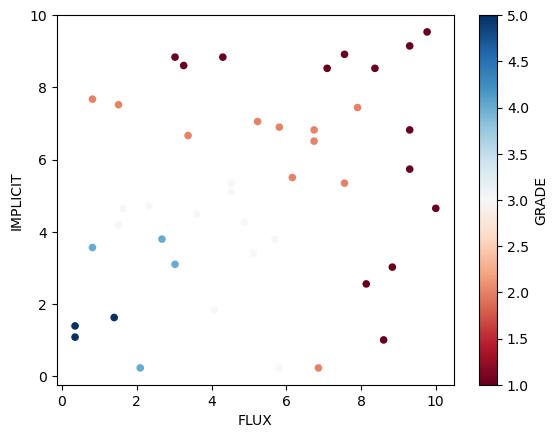

In [ ]:
LINE,GRADE=(2,1)
EXCLUDE_STATION = get_exclude_list(LINE,GRADE)
g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
g_dist = dist_weight_graph()

draw_func(LINE)

print(
f"""LINE, GRADE = {LINE, GRADE}
{calc_line_speed(LINE,g_dist=g_dist,g_time=g_time):.2f} [km/h]
{calc_line_spend_time(LINE,g_time=g_time)} [second]
{get_grade(LINE,GRADE)} is Selected by GRADE {GRADE} 
{get_exclude_list(LINE, GRADE)[:5] if len(get_exclude_list(LINE, GRADE)) > 5 else get_exclude_list(LINE, GRADE)} ... and more will be exclude"""
)